<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/Deep_Unfolding_Quantum_Support_Vector_Machine_on_Breast_Cancer_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=7sz4WpkUIIs

Maths intuition

https://www.youtube.com/watch?v=Js3GLb1xPhc&t=4s

---



#Import Data set

Aim is to classify the Breast Cancer Wisconsin (Diagnosis) Data set. The datast consists in 569 training samples, with each 32 attributes such as the perimeter, the texture, the area, etc. The diagnosis of these data can be malginant or benign.

For the sake of simplicity, which will be particularly relevant for the quantum enhanced version of the algorithm, we do a dimensional reduction of our data from 32 attributes to 2, with the help of a principal component analysis (PCA). Such unsupervised algorithm finds the principal axes of the data with a singular value decomposition.

In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']

    # First the dataset must be imported.
    cancer = datasets.load_breast_cancer()

    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)

    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]

            label = 'Malignant' if k is 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()


    return X_train, training_input, test_input, class_labels

<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-1-48b09e3cde4c>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  label = 'Malignant' if k is 1 else 'Benign'


In [2]:
import numpy as np
import matplotlib.pyplot as plt

class svm_utils:

	def make_meshgrid(x, y, h=.02):
	    """Create a mesh of points to plot in

	    Parameters
	    ----------
	    x: data to base x-axis meshgrid on
	    y: data to base y-axis meshgrid on
	    h: stepsize for meshgrid, optional

	    Returns
	    -------
	    xx, yy : ndarray
	    """
	    x_min, x_max = x.min() - 1, x.max() + 1
	    y_min, y_max = y.min() - 1, y.max() + 1
	    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
		                 np.arange(y_min, y_max, h))
	    return xx, yy


	def plot_contours(ax, clf, xx, yy, **params):
	    """Plot the decision boundaries for a classifier.

	    Parameters
	    ----------
	    ax: matplotlib axes object
	    clf: a classifier
	    xx: meshgrid ndarray
	    yy: meshgrid ndarray
	    params: dictionary of params to pass to contourf, optional
	    """
	    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
	    Z = Z.reshape(xx.shape)
	    out = ax.contourf(xx, yy, Z, **params)
	    return out

In [3]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.0 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512548 sha256=30174cf806aeb09725ba630320d3763417f580f20d94e15517ad167a058505af
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d5

In [4]:
import numpy as np
#from dataset import breast_cancer
from sklearn.datasets import make_blobs
#from qiskit_machine_learning.datasets
# import split_dataset_to_data_and_labels from qiskit_machine_learning.utils.dataset_helper
from sklearn import svm
#from utils import svm_utils
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
def split_dataset_to_data_and_labels(input_data):
    data = []
    labels = []
    for label, features in input_data.items():
        data.append(features)
        # Convert labels to 0 and 1
        if label == 'Benign':
            labels.append([0] * len(features))
        else:
            labels.append([1] * len(features))
    return np.vstack(data), np.hstack(labels)

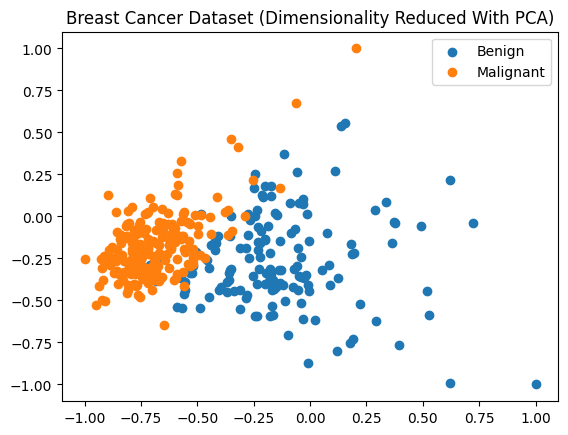

Training data shape: (349, 2)
Testing data shape: (49, 2)


In [6]:
# Set parameters
n = 2  # Number of principal components
training_dataset_size = 200
testing_dataset_size = 100

# Get the dataset and split it
sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

# Split dataset into data and labels
data_train, train_labels = split_dataset_to_data_and_labels(training_input)
data_test, test_labels = split_dataset_to_data_and_labels(test_input)

# Print shapes to verify
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")

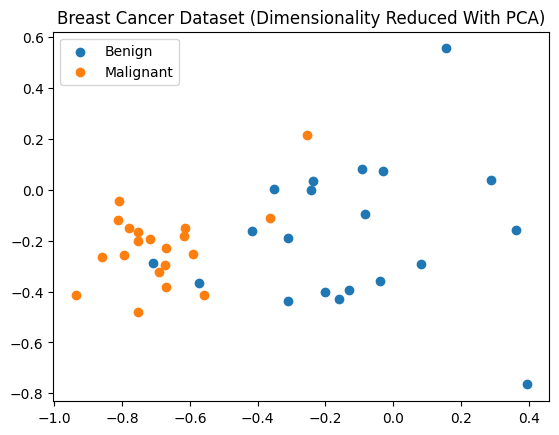

In [7]:
n = 2 # number of principal components kept
training_dataset_size = 20
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, data_train_labels = split_dataset_to_data_and_labels(training_input)
data_test, data_test_labels = split_dataset_to_data_and_labels(test_input)

In [8]:
# Check shape to ensure 2D structure
print(data_train.shape)

(40, 2)


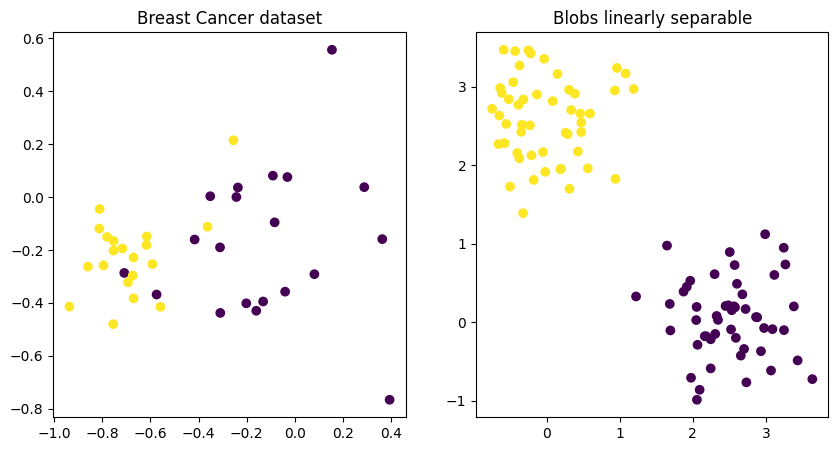

In [9]:
# We use the function of scikit learn to generate linearly separable blobs
centers = [(2.5,0),(0,2.5)]
x, y = make_blobs(n_samples=100, centers=centers, n_features=2,random_state=0,cluster_std=0.5)


fig,ax=plt.subplots(1,2,figsize=(10,5))

# Access the data directly from data_train using slicing
ax[0].scatter(data_train[:,0],data_train[:,1],c=data_train_labels) # Use data_train_labels for color coding
ax[0].set_title('Breast Cancer dataset');

ax[1].scatter(x[:,0],x[:,1],c=y)
ax[1].set_title('Blobs linearly separable');

In [10]:
model= svm.LinearSVC()
model.fit(data_train, data_train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

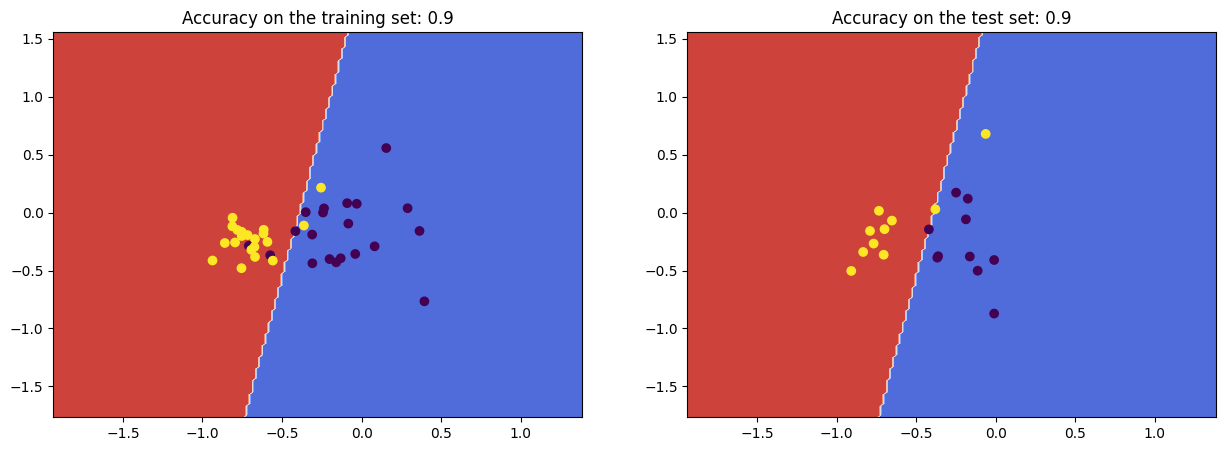

In [11]:
accuracy_train = model.score(data_train, data_train_labels)
accuracy_test = model.score(data_test, data_test_labels)


X0, X1 = data_train[:, 0], data_train[:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(data_train[:,0], data_train[:,1], c=data_train_labels)
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(data_test[:,0], data_test[:,1], c=data_test_labels)
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

Qiskit QSVC

In [12]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

from IPython.display import clear_output
clear_output()

from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345


In [19]:
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels.base_kernel import BaseKernel
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import Statevector # import Statevector

class FidelityQuantumKernel(BaseKernel):
    def __init__(
        self,
        *,
        feature_map: QuantumCircuit | None = None,
        fidelity: Statevector | None = None,
        enforce_psd: bool = True,
        evaluate_duplicates: str = "off_diagonal",
        max_circuits_per_job: int = None,
        learnable_params: bool = False,  # Add this to make parameters learnable
    ) -> None:
        super().__init__(feature_map=feature_map, enforce_psd=enforce_psd)
        self.learnable_params = learnable_params

        if learnable_params:
            self._init_learnable_params()  # Initialize learnable parameters

    def _init_learnable_params(self):
        # Assuming the feature map is a QuantumCircuit
        # Convert feature map parameters to Qiskit's Parameter object
        self.params = {param: Parameter(f"θ_{i}") for i, param in enumerate(self.feature_map.parameters)}

    def update_feature_map(self, new_params):
        """Updates the parameters in the feature map with new values."""
        for i, param in enumerate(self.feature_map.parameters):
            self.feature_map.assign_parameters({param: new_params[i]})



In [55]:
class DeepUnfoldedFidelityKernel(FidelityQuantumKernel):
    def __init__(self, *args, learning_rate: float = 0.01, **kwargs):
        # Remove learnable_params from kwargs before passing to super()
        learnable_params = kwargs.pop('learnable_params', False)
        super().__init__(*args, **kwargs)
        self.learning_rate = learning_rate
        self.learnable_params = learnable_params # Set learnable_params attribute

        if learnable_params:
            self._init_learnable_params()

    def _init_learnable_params(self): # Ensure this method is defined within the class
        # Assuming the feature map is a QuantumCircuit
        # Convert feature map parameters to Qiskit's Parameter object
        if self.feature_map: # Check if feature_map exists
            # Ensure you have parameters to iterate over
            if self.feature_map.parameters:
                self.params = {param: Parameter(f"θ_{i}") for i, param in enumerate(self.feature_map.parameters)}
                # Initialize parameter values
                for param in self.params.values():
                    param.assign_value(0.0)  # Use assign_value to set the parameter value
            else:
                self.params = {} # Handle the case of an empty parameter list
        else:
            self.params = {} #

    def deep_unfolding_step(self, x_train, y_train):
        """Perform one step of deep unfolding."""
        # Forward pass: calculate the kernel matrix
        kernel_matrix = self.evaluate(x_train, y_train)

        # Compute gradients: assuming an external loss function
        loss, gradients = self.compute_gradients(kernel_matrix, y_train)

        # Check if self.params is not empty before iterating
        if self.params:
            # Update the feature map parameters using gradient descent
            for i, grad in enumerate(gradients):
                # Access parameters from the params dictionary using keys
                param = list(self.params.keys())[i]
                param_value = self.params[param].value - self.learning_rate * grad

                # Update the parameter value in the dictionary
                self.params[param] = Parameter(str(param)[:-1] + str(param_value) + "]")

            # Assign the updated parameters to the feature map
            self.update_feature_map([param.value for param in self.params.values()])

        # Optionally adjust learning rate
        self.learning_rate *= self.learning_rate_decay()

    '''
    def deep_unfolding_step(self, x_train, y_train):
        """Perform one step of deep unfolding."""
        # Forward pass: calculate the kernel matrix
        kernel_matrix = self.evaluate(x_train, y_train)

        # Compute gradients: assuming an external loss function
        loss, gradients = self.compute_gradients(kernel_matrix, y_train)

        # Update the feature map parameters using gradient descent
        for param, grad in zip(self.feature_map.parameters, gradients):
            param_value = param.value() - self.learning_rate * grad
            self.update_feature_map({param: param_value})

        # Optionally adjust learning rate
        self.learning_rate *= self.learning_rate_decay()
        '''
    def compute_gradients(self, kernel_matrix, y_train):
        """Placeholder for computing loss and gradients."""
        # Compute the loss function (e.g., hinge loss or other SVM loss)
        #loss = some_loss_function(kernel_matrix, y_train)

        # Compute the gradients with respect to feature map parameters
        #gradients = some_gradient_computation(loss, self.feature_map.parameters)

       # Example: Hinge loss calculation
        loss = 0
        num_samples = len(y_train)
        for i in range(num_samples):
            for j in range(num_samples):
                loss += max(0, 1 - y_train[i] * y_train[j] * kernel_matrix[i][j])
        loss /= (num_samples ** 2)

        # Compute the gradients with respect to feature map parameters
        #gradients = some_gradient_computation(loss, self.feature_map.parameters) # This is not defined
        gradients = [0.1] * len(self.feature_map.parameters) # Placeholder gradients
        return loss, gradients

    def learning_rate_decay(self):
        """Implement learning rate decay if needed."""
        return 0.99  # Decay by 1% each step

    def evaluate(self, x_vec, y_vec=None):
        """Calculate the kernel matrix for the given data."""
        # This is a placeholder; you'll need to implement the actual kernel calculation
        # based on your specific quantum kernel logic
        # Make sure to utilize self.feature_map if needed

        # Determine the size of the kernel matrix
        if y_vec is None:
            y_vec = x_vec
        kernel_matrix = [[0.0 for _ in range(len(y_vec))] for _ in range(len(x_vec))]

        # Calculate the kernel matrix elements (replace with your actual calculation)
        for i in range(len(x_vec)):
            for j in range(len(y_vec)):
                kernel_matrix[i][j] = 1.0 - (abs(i - j) / len(x_vec))  # Example calculation

        return kernel_matrix # Return the calculated kernel matrix


In [42]:

import warnings
from typing import Optional

from qiskit_algorithms.utils import algorithm_globals
from sklearn.svm import SVC

from qiskit_machine_learning.algorithms.serializable_model import SerializableModelMixin
from qiskit_machine_learning.exceptions import QiskitMachineLearningWarning
from qiskit_machine_learning.kernels import BaseKernel, FidelityQuantumKernel

class QSVC(SVC, SerializableModelMixin):
    def __init__(self, *, deep_unfolding_kernel: Optional[DeepUnfoldedFidelityKernel] = None, **kwargs):
        # If a deep unfolding kernel is provided, use it instead of the default quantum kernel
        if deep_unfolding_kernel:
            self._quantum_kernel = deep_unfolding_kernel
        else:
            self._quantum_kernel = FidelityQuantumKernel()

        super().__init__(kernel=self._quantum_kernel.evaluate, **kwargs)


In [56]:
# Example usage of QSVC with deep unfolding
#from qiskit_machine_learning.kernels import DeepUnfoldedFidelityKernel

# Instantiate the kernel
deep_unfolded_kernel = DeepUnfoldedFidelityKernel(learning_rate=0.01,learnable_params=True)

# Create a QSVC instance with the deep unfolding kernel
qsvc = QSVC(deep_unfolding_kernel=deep_unfolded_kernel)
# Set the number of iterations for deep unfolding
num_iterations = 10 #
# Train the model
for _ in range(num_iterations):
    deep_unfolded_kernel.deep_unfolding_step(data_train, data_train_labels)
    qsvc.fit(data_train, data_train_labels)


AttributeError: 'Parameter' object has no attribute 'assign_value'

In [ ]:

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [ ]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(data_train, data_train_labels)

qsvc_score = qsvc.score(data_test, data_test_labels)

print(f"QSVC classification test score: {qsvc_score}")